In [47]:
import json
import re
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import itertools
import operator
from nltk.tokenize import word_tokenize
from collections import Counter
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import ldamodel

In [3]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
from nltk.corpus import stopwords
noise = stopwords.words('russian') + list(punctuation) + ['``', '...', "''"]
noise[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [5]:
import sys
print(sys.version)

3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]


In [6]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:56, 3552.94it/s]



Посмотрим на пример отзыва:

In [7]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [8]:
df = pd.DataFrame(responses)
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [10]:
df.city.unique()

array(['г. Москва', 'г. Новосибирск', 'г. Ставрополь', ...,
       'г. Москва-Владимир', 'г. СПб.',
       'г. Краснодарский край, ст.Павловская'], dtype=object)

In [11]:
def remove_stopwords(text, mystopwords=noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [12]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [13]:
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [14]:
df['text_tokinized_stop_worlds'] = df.text_tokinized.str.lower().apply(remove_stopwords)

In [15]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [16]:
df['lemma'] = df['text_tokinized_stop_worlds'].apply(lemmatize)

In [17]:
df.head(1)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stop_worlds,lemma
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...


### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.  

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.   

Тексты хранятся в json-ах в массиве responses.   

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.   

#### Часть 1. Анализ текстов  
1) Посчитайте количество отзывов в разных городах и на разные банки  
2) Постройте гистограмы длин слов в символах и в словах  
3) Найдите 10 самых частых:  
- слов  
- слов без стоп-слов  
- лемм  
- существительных  
4) Постройте кривые Ципфа и Хипса  
5) Ответьте на следующие вопросы:  
- какое слово встречается чаще, "сотрудник" или "клиент"?  
- сколько раз встречается слова "мошенничество" и "доверие"?  
6) В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру   
tf−idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

#### Посчитайте количество отзывов в разных городах

In [9]:
df['city'].value_counts()

г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 5823, dtype: int64

#### Посчитайте количество отзывов на разные банки

In [10]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

In [11]:
df_pv = pd.pivot_table(df.reset_index(), values='index', index=['city', 'bank_name'], aggfunc='count', sort=True)
df_pv.reset_index().sort_values(by=['index'], ascending = False).rename(columns={'index': 'Count of scores'}).head(5)

,city,bank_name,Count of scores
7453,г. Москва,Сбербанк России,8146
7160,г. Москва,Альфа-Банк,3871
7437,г. Москва,Русский Стандарт,2801
7206,г. Москва,ВТБ 24,2714
12394,г. Санкт-Петербург,Сбербанк России,2434


#### Постройте гистограмы отзывов длин в символах и в словах

In [32]:
def word_count(x):
    tokens = nltk.word_tokenize(x)
    return len(tokens)

In [33]:
def len_symbol(x):
    return len(x)

In [34]:
df['word_count'] = df.lemma.apply(lambda x: word_count(x))

In [35]:
df['len_symbol'] = df.lemma.apply(lambda x: len_symbol(x))

In [36]:
df.head(1)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokinized,text_tokinized_stop_worlds,lemma,word_count,len_symbol
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...,146,1200


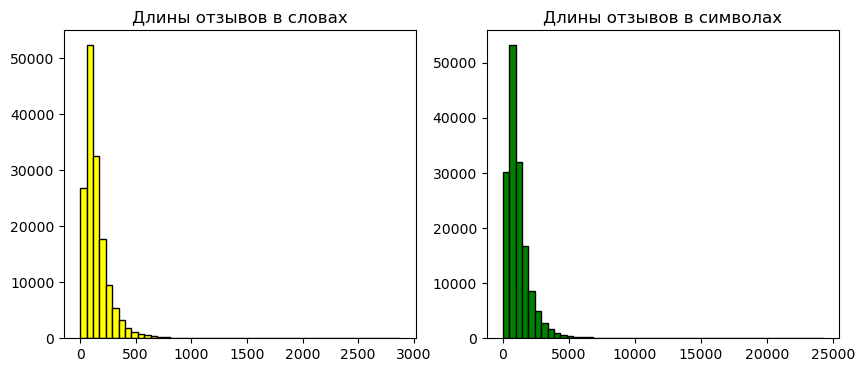

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(df.word_count, bins=50, color='Yellow', edgecolor='black')
axs[0].set_title('Длины отзывов в словах')
plt.ylabel('')

axs[1].hist(df.len_symbol, bins=50, color='Green', edgecolor='black')
axs[1].set_title('Длины отзывов в символах')
plt.ylabel('')
plt.show()

#### Найдите 10 самых частых

In [9]:
# corpus = [token for review in df.text for token in word_tokenize(review) if token not in punctuation]
# print(len(corpus))

#### - слов

In [24]:
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1322516),
 ('и', 1054485),
 ('не', 851742),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454545),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263957)]

#### - слов без стоп-слов

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
corpus = [token for review in df.text for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банка', 263957),
 ('банк', 196303),
 ('это', 183054),
 ('деньги', 130062),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80282),
 ('день', 75996),
 ('заявление', 69524),
 ('отделение', 66468)]

#### - лемм

In [14]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
lemmatizer = MorphAnalyzer()

In [87]:
def my_preproc(x, stopwords = noise):
    return lemmatizer.parse(x)[0].normal_form

In [91]:
corpus = [my_preproc(token) for review in df.sample(frac=0.2).text for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банк', 124044),
 ('карта', 66531),
 ('это', 39532),
 ('деньга', 35518),
 ('день', 34102),
 ('мой', 32796),
 ('кредит', 30458),
 ('который', 29347),
 ('отделение', 28571),
 ('счёт', 28167)]

#### существительных

In [93]:
def my_preproc_noun(x, stopwords = noise):
    x = lemmatizer.parse(x)[0]
    if x.tag.POS == 'NOUN':
        return x.normal_form

In [94]:
corpus = [my_preproc_noun(token) for review in df.sample(frac=0.1).text for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)

[(None, 1300521),
 ('банк', 62492),
 ('карта', 32963),
 ('деньга', 17536),
 ('день', 17163),
 ('кредит', 15514),
 ('счёт', 14189),
 ('отделение', 14078),
 ('клиент', 13189),
 ('сотрудник', 13156)]

In [95]:
freq_dict.most_common(11)

[(None, 1300521),
 ('банк', 62492),
 ('карта', 32963),
 ('деньга', 17536),
 ('день', 17163),
 ('кредит', 15514),
 ('счёт', 14189),
 ('отделение', 14078),
 ('клиент', 13189),
 ('сотрудник', 13156),
 ('сумма', 11651)]

#### Постройте кривые Ципфа и Хипса

In [100]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in noise])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 153499/153499 [11:13<00:00, 227.79it/s]


In [101]:
corpus = [token for review in tqdm(df.text) for token in word_tokenize(review) if token not in noise]
freq_dict = Counter(corpus)

100%|██████████| 153499/153499 [05:08<00:00, 498.06it/s] 


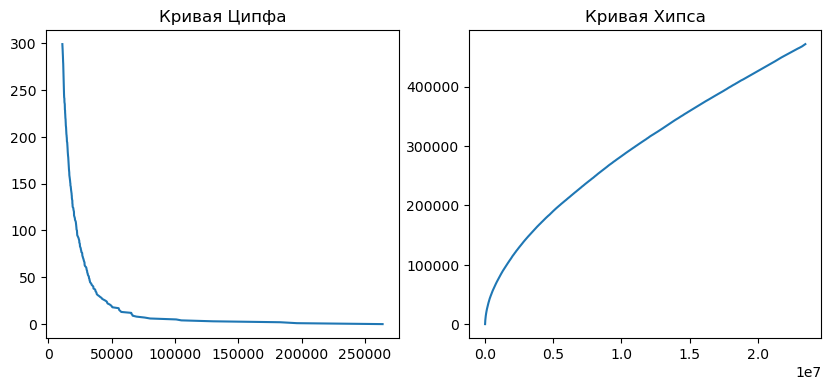

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

axs[0].plot(freqs[:300], range(300))
axs[0].set_title('Кривая Ципфа')

axs[1].plot(n_tokens, n_words)
axs[1].set_title('Кривая Хипса')

plt.show()

#### какое слово встречается чаще, "сотрудник" или "клиент"?

In [106]:
freq_dict['сотрудник']

30994

In [108]:
freq_dict['клиент']

17754

Встречается чаще сотрудник

#### сколько раз встречается слова "мошенничество" и "доверие"?

In [111]:
freq_dict['мошенничество']

1102

In [112]:
freq_dict['доверие']

1153

Корректнее брать уже леммы, но так быстрее

#### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf−idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [18]:
df5 = df[(df['rating_grade'] == 5.0) & (df['lemma'].isna() == False)].reset_index()[['lemma', 'rating_grade']]

In [19]:
df1 = df[(df['rating_grade'] == 1.0) & (df['lemma'].isna() == False)].reset_index()[['lemma', 'rating_grade']]

In [11]:
# corpus5 = [my_preproc(token) for review in tqdm(df5.text) for token in word_tokenize(review) if token not in noise]

In [12]:
# corpus1 = [my_preproc(token) for review in tqdm(df1.text) for token in word_tokenize(review) if token not in noise]

In [40]:
vectorizer5 = TfidfVectorizer()
tfidf_matrix5 = vectorizer5.fit_transform(df5['lemma'])

In [41]:
tfidf_df5 = pd.DataFrame(tfidf_matrix5.toarray(), columns=vectorizer5.get_feature_names_out())

In [42]:
iter = 0
for index, row in tfidf_df5.iterrows():
    print(f"Отзыв {index + 1}:")
    print(row.sort_values(ascending=False).head(5))
    iter += 1
    if iter == 2:
        break

Отзыв 1:
ленсовет      0.352249
озерко        0.288519
прикрывать    0.274097
заказывать    0.270142
вклад         0.244206
Name: 0, dtype: float64
Отзыв 2:
вклад        0.464385
доходный     0.348977
взнос        0.246393
открывать    0.219757
счет         0.203576
Name: 1, dtype: float64


In [23]:
df1 = df1.sample(frac=0.1)

In [24]:
vectorizer1 = TfidfVectorizer()
tfidf_matrix1 = vectorizer1.fit_transform(df1['lemma'])

In [25]:
tfidf_df1 = pd.DataFrame(tfidf_matrix1.toarray(), columns=vectorizer1.get_feature_names_out())

In [26]:
iter = 0
for index, row in tfidf_df1.iterrows():
    print(f"Отзыв {index + 1}:")
    print(row.sort_values(ascending=False).head(5))
    iter += 1
    if iter == 2:
        break

Отзыв 1:
счет            0.315559
доверенность    0.278656
номер           0.218704
вставать        0.202844
посмотреть      0.200072
Name: 0, dtype: float64
Отзыв 2:
альфа             0.273331
номер             0.244915
сверять           0.212166
расплачиваться    0.168576
смена             0.162825
Name: 1, dtype: float64


#### Использование биграмм

In [20]:
tfidf_bi = TfidfVectorizer(analyzer='word', ngram_range=(2,2))
tfidf_matrix_bi = tfidf_bi.fit_transform(df5['lemma'])

In [21]:
tfidf_df_bi = pd.DataFrame(tfidf_matrix_bi.toarray(), columns=tfidf_bi.get_feature_names_out())

In [24]:
iter = 0
for index, row in tfidf_df_bi.iterrows():
    print(f"Отзыв {index + 1}:")
    print(row.sort_values(ascending=False).head(5))
    iter += 1
    if iter == 2:
        break

Отзыв 1:
значительный работать    0.192611
жаль прикрывать          0.192611
озерко доступность       0.192611
заказывать сотрудник     0.192611
лишний жаль              0.192611
Name: 0, dtype: float64
Отзыв 2:
вклад доходный    0.257474
счет вклад        0.224034
месяц месяц       0.170592
мочь открывать    0.168614
открывать счет    0.149463
Name: 1, dtype: float64


### Тематическое моделирование

In [18]:
df_cut = df.sample(frac=0.1)

In [20]:
texts = [df_cut['lemma'].iloc[i].split() for i in range(len(df_cut))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [22]:
import random
random.seed(11)

In [23]:
lda = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [24]:
lda.show_topics(5)

[(1,
  '0.058*"автосалон" + 0.057*"райффайзен" + 0.050*"райффайзенбанк" + 0.028*"вал" + 0.027*"монета" + 0.022*"допофис" + 0.020*"земляной" + 0.014*"совок" + 0.014*"нпф" + 0.013*"мониторинг"'),
 (2,
  '0.033*"курс" + 0.029*"валюта" + 0.029*"рубль" + 0.028*"доллар" + 0.023*"евро" + 0.021*"банк" + 0.016*"сумма" + 0.015*"валютный" + 0.014*"купюра" + 0.011*"деньги"'),
 (17,
  '0.040*"сбербанк" + 0.039*"отделение" + 0.031*"деньги" + 0.029*"день" + 0.023*"счет" + 0.019*"заявление" + 0.014*"мой" + 0.013*"сказать" + 0.012*"обращаться" + 0.011*"банк"'),
 (13,
  '0.021*"банк" + 0.018*"очередь" + 0.017*"клиент" + 0.017*"отделение" + 0.013*"работать" + 0.011*"человек" + 0.010*"это" + 0.010*"минута" + 0.009*"время" + 0.009*"свой"'),
 (3,
  '0.028*"банк" + 0.026*"звонить" + 0.014*"телефон" + 0.014*"это" + 0.013*"говорить" + 0.013*"звонок" + 0.012*"сказать" + 0.011*"ваш" + 0.011*"отвечать" + 0.011*"сотрудник"')]

1. обращение либо в райф по поводу нпф, либо по поводу перевода в райф
3. обращение в сбер по поводу перевода

In [33]:
lda10 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=10, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)
# 10 тем, рандомная выборка 5
lda10.show_topics(5)

[(6,
  '0.044*"кредит" + 0.028*"документ" + 0.024*"банк" + 0.017*"заявка" + 0.017*"день" + 0.015*"договор" + 0.013*"страховка" + 0.012*"справка" + 0.011*"оформлять" + 0.011*"менеджер"'),
 (8,
  '0.049*"сбербанк" + 0.022*"счет" + 0.022*"г" + 0.021*"отделение" + 0.019*"средство" + 0.019*"мой" + 0.018*"заявление" + 0.013*"денежный" + 0.011*"обращаться" + 0.011*"обращение"'),
 (2,
  '0.033*"банк" + 0.017*"звонок" + 0.017*"звонить" + 0.017*"номер" + 0.016*"телефон" + 0.016*"сотрудник" + 0.015*"ваш" + 0.014*"мой" + 0.010*"день" + 0.009*"который"'),
 (7,
  '0.016*"это" + 0.013*"банк" + 0.012*"сказать" + 0.010*"говорить" + 0.009*"приходить" + 0.008*"девушка" + 0.007*"вс" + 0.006*"такой" + 0.006*"мочь" + 0.006*"который"'),
 (3,
  '0.036*"банк" + 0.021*"вклад" + 0.017*"клиент" + 0.013*"отделение" + 0.012*"офис" + 0.010*"очень" + 0.009*"очередь" + 0.009*"сотрудник" + 0.009*"открывать" + 0.008*"работать"')]

## Классификация текстов

In [38]:
size_sample = 10000
sample5 = df.loc[df.rating_grade == 5][['rating_grade', 'lemma']].sample(size_sample)
sample1 = df.loc[df.rating_grade == 1][['rating_grade', 'lemma']].sample(size_sample)
df_51 = pd.concat([sample5, sample1], axis=0)
df_51.shape

(20000, 2)

In [41]:
X = df_51['lemma'].values
y = df_51.rating_grade.values

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 
n-грам.

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [54]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word'],
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3))
}

scores=['accuracy', 'f1']

In [55]:
grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [56]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'vect__analyzer': ['word'],
                         'vect__ngram_range': ((1, 1), (2, 2), (3, 3))},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [59]:
res = pd.DataFrame(grid_cntv.cv_results_)
res[['param_vect__ngram_range', 'mean_test_f1', 'mean_test_accuracy']]

,param_vect__ngram_range,mean_test_f1,mean_test_accuracy
0,"(1, 1)",0.940092,0.940071
1,"(2, 2)",0.913701,0.913857
2,"(3, 3)",0.740529,0.778857


In [60]:
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.940


лучший результат с униграммами

Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков

1-ый вариант: 
tf−idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)

In [63]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'tfidf__use_idf': (True, False)
}

scores=['accuracy','f1']

In [64]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf, 
    param_grid=params_tf_idf, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [65]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tfidf__use_idf': (True, False),
                         'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [66]:
# print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.941


In [67]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)

In [68]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94      3007
         5.0       0.95      0.93      0.94      2993

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [69]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'tsvd__n_components': [5, 10, 25]
}

scores=['accuracy','f1']

In [70]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD, 
    param_grid=params_tf_idf_TruncatedSVD, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [71]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('tsvd', TruncatedSVD()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tsvd__n_components': [5, 10, 25],
                         'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [72]:
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.907


In [73]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [74]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91      3007
         5.0       0.92      0.90      0.91      2993

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [78]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25]
}

scores=['accuracy', 'f1']

In [79]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA, 
    param_grid=params_tf_idf_LDA, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [80]:
grid_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('lda', LatentDirichletAllocation()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lda__n_components': [25], 'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [81]:
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.884


In [82]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [83]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.92      0.91      3007
         5.0       0.92      0.89      0.90      2993

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



## Итого
𝑡𝑓−𝑖𝑑𝑓 наиболее удачная модель